In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import statsmodels.api as sm
import glob
from sklearn import preprocessing
import matplotlib.colors as colors

### Importing the NCEP Reanalysis datasets

In [2]:
# Reading in sea level pressure data
slp = xr.open_dataset('slp.mon.mean.nc')

# Reading in surface temperature data
ts = xr.open_dataset('air.mon.mean.nc')

# Adding months to both datasets for later grouping
months = np.arange(start=1, stop=13, step=1).tolist() * (876//12) # 876 because thats how many months there are in this dataset divided by 12 months. Will remove last 5 months as that data does not exist yet
months = months[:len(months)-5]

ts['months'] = months
slp['months'] = months

### Lets plot this data to see what it looks like

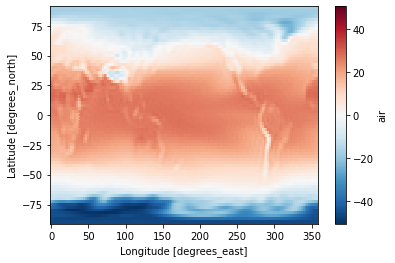

In [17]:
# Average temperature throughout this time series
ts['air'].mean('time').plot()

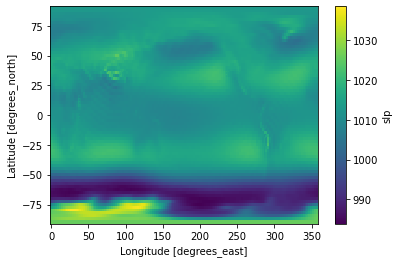

In [18]:
# Average sea level pressure through this time series
slp['slp'].mean('time').plot()

### Calculating the NAO index as defined in Hurrell (1995, Science)

The NAO Index is defined here as the normalized pressure between Lisbon, Spain and Stykkisholmur, Iceland. Why is this the definition? It's because both of these locations have had meteorological stations since 1899 and pressure readings consistently to present day. Newer definitions have been used and suggested, but for the sake of this figure and demonstration, we will be using the standard definition:

$$
\text{NAO Index} = \frac{P_{south} - \overline{P_{south}}}{std(P_{south})} - \frac{P_{north} - \overline{P_{north}}}{std(P_{north})}
$$

Where, the average corresponds to the entire time series and the standard deviation corresponds to the entire time series.

In [19]:
# The two locations used in the calculation of the NAO index
lisbon = (38.725267, 350.849981)
stykkisholmur = (65.075, 337.275)

# Selecting the time series for Lisbon and Stykkisholmur
lis = slp.sel(lat=lisbon[0], method='nearest').sel(lon=lisbon[1], method='nearest')
styk = slp.sel(lat=stykkisholmur[0], method='nearest').sel(lon=stykkisholmur[1], method='nearest')

# Mean of the entire time series
lis_mean = slp.sel(lat=lisbon[0], method='nearest').sel(lon=lisbon[1], method='nearest').mean()
sty_mean = slp.sel(lat=stykkisholmur[0], method='nearest').sel(lon=stykkisholmur[1], method='nearest').mean()

# Standard deviation of the entire time series
lis_std = np.std(slp.sel(lat=lisbon[0], method='nearest').sel(lon=lisbon[1], method='nearest'))
sty_std = np.std(slp.sel(lat=stykkisholmur[0], method='nearest').sel(lon=stykkisholmur[1], method='nearest'))

# NAO Index calculation following the above formula
nao_index = ((lis - lis_mean)/lis_std) - ((styk - sty_mean)/sty_std)

With the NAO Index calculated, lets plot the time series

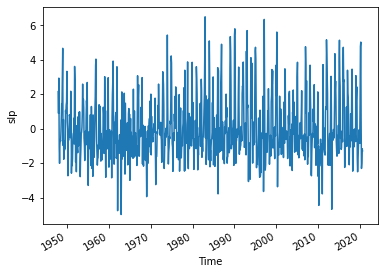

In [20]:
nao_index['slp'].plot()

### Correlation of the NAO Index to the temperature

This is performed by performing a least-squares regression of the NAO Index time series with the temperature time series from each grid cell. This will be accomplished by flattening the spatially explicit temperature data for each year into a  vector and the performing two loops. The first loop will go through the months in the temperature data and the next will go through the points. The NAO Index is scaled to unit variance to aid in interpretation, where and increase in temperature corresponds to a one standard deviation change in the NAO Index.

In [21]:
# Extracting latitude and longitude values from the temperature data
x = ts['lon']
y = ts['lat']

# Creating a meshgrid of the values to be used in loops
mesh_x, mesh_y = np.meshgrid(x, y)

# Flattening the meshgrid values to work directly within the loop
x_flat = mesh_x.flatten()
y_flat = mesh_y.flatten()

Loop to perform least squares regression of the NAO Index times series with the temperature time series

In [23]:
# Run the loop if the data is not already saved
if len(glob.glob("nao_corr.nc")) < 1: 
    
    # NAO Index as a array for regression
    nao = nao_index['slp'].values

    # Lists to hold values
    slope = list()
    p_value = list()
    
    # Getting groups
    groups = nao_index.groupby('months').groups # Dictionary of month group/time pairings
    group_keys = np.arange(start=1, stop=13, step=1) # Months that serve as keys

    # Loop on a zipped iterator of the two dimensions
    for ii in group_keys:
        month_slope = list()
        month_p_value = list()
        for point in zip(x_flat, y_flat):
            air = ts.isel(time=groups[ii]).sel(lon=point[0]).sel(lat=point[1])['air'].values
            X = sm.add_constant(preprocessing.scale(nao_index.isel(time=groups[ii])['slp'].values))
            model = sm.OLS(air, X)
            results = model.fit()
            month_slope.append(results.params[1])
            month_p_value.append(results.t_test([0, 1]).pvalue)
        slope.append(month_slope)
        p_value.append(month_p_value) 
else:
    nao_corr = xr.open_dataset('nao_corr.nc')

### Save results into a netCDF

The for loop above take ~360 minutes to run. Since this plot is meant to be illustrative, the output will be saved into a netCDF by xarray so that the entire notebook does not have to be run if the netCDF is present.

In [24]:
# Save to netCDF4 if the data does not already exist
if len(glob.glob("nao_corr.nc")) < 1: 
    
    # Reshaping from flat list to the lat, lon dimensions of the source data
    slope_np = np.reshape(slope, newshape=(12, 73, 144))
    p_value_np = np.reshape(p_value, newshape=(12, 73, 144))

    # Creating xarray containing the slope and p-value data
    nao_corr = xr.Dataset(
                    {
                        "slope":(["month", "x", "y"], slope_np),
                        "p_value":(["month", "x", "y"], p_value_np),
                    },
                    coords={
                        "lon": (["x", "y"], mesh_x),
                        "lat": (["x", "y"], mesh_y),
                        "month": np.arange(start=1, stop=13, step=1),
                    }
                )

    # Saving to netCDF
    nao_corr.to_netcdf(path='nao_corr.nc', mode='w', format='NETCDF4')

### Plot the final results for the winter (DJF)

<ipython-input-25-250a42914d52>:10: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  cb = ax.pcolormesh(lon_cyc, slope_djf['lat'].values[:,0], slope_cyc, transform=ccrs.PlateCarree(), cmap='RdBu_r', norm=colors.DivergingNorm(vcenter=0, vmin=-3, vmax=3))


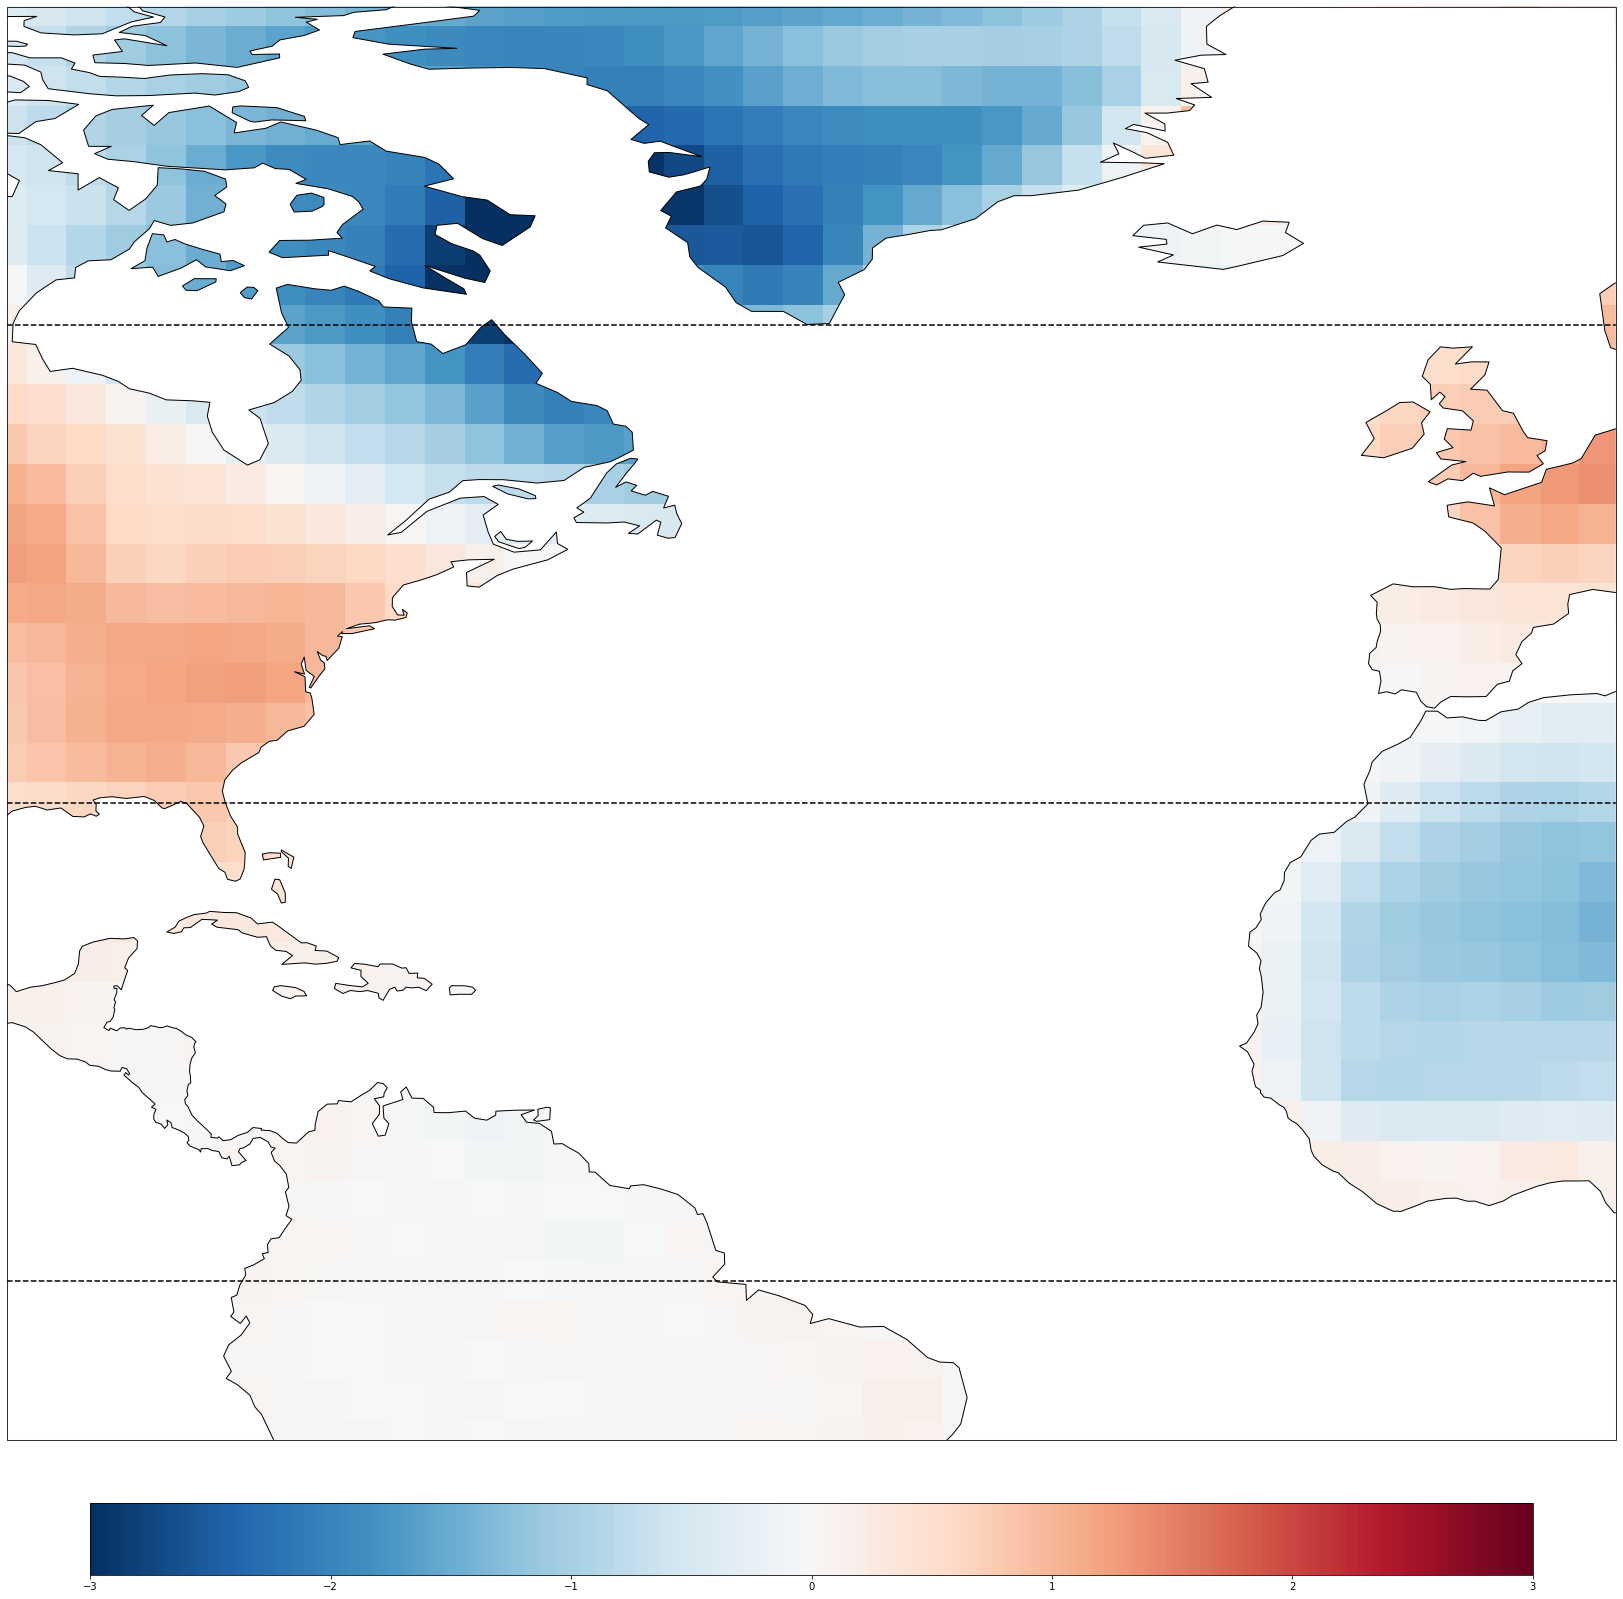

In [25]:
# Take DJF average first
slope_djf = nao_corr.isel(month=[0, 1, 11]).mean('month')

# Creating cyclic point to avoid the blank line
slope_cyc, lon_cyc = add_cyclic_point(slope_djf['slope'], coord=slope_djf['lon'].values[0])

# Generate final plot
fig = plt.figure(figsize = (28.85, 28.85))
ax = plt.axes(projection=ccrs.PlateCarree())
cb = ax.pcolormesh(lon_cyc, slope_djf['lat'].values[:,0], slope_cyc, transform=ccrs.PlateCarree(), cmap='RdBu_r', norm=colors.DivergingNorm(vcenter=0, vmin=-3, vmax=3))
plt.xlim(-95, 6)
plt.ylim(-10, 80)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.axhline(y=30, color='black', linestyle='dashed')
plt.axhline(y=60, color='black', linestyle='dashed')
ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=1, edgecolor='k')
plt.colorbar(cb, orientation='horizontal', fraction=0.046, pad=0.04)

# Save final plot as pdf
plt.savefig('north_atlantic_basemap.pdf', dpi=300, bbox_inches='tight')

### Diagnostic - add points for every grid cell with a significant relationship (<0.05)

This will require filtering the 'p_value' data array to determine which lat/lon points can be removed because they are greater than 0.05

In [26]:
# Using numpy to filter the lat/lon based on the p_values
p_value_djf = slope_djf['p_value'].values.flatten()
p_value_lat = y_flat[p_value_djf < 0.05]
p_value_lon = x_flat[p_value_djf < 0.05]

<ipython-input-27-51d5fce1e4b3>:4: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  cb = ax.pcolormesh(lon_cyc, slope_djf['lat'].values[:,0], slope_cyc, transform=ccrs.PlateCarree(), cmap='seismic', norm=colors.DivergingNorm(vcenter=0, vmin=-3, vmax=3))


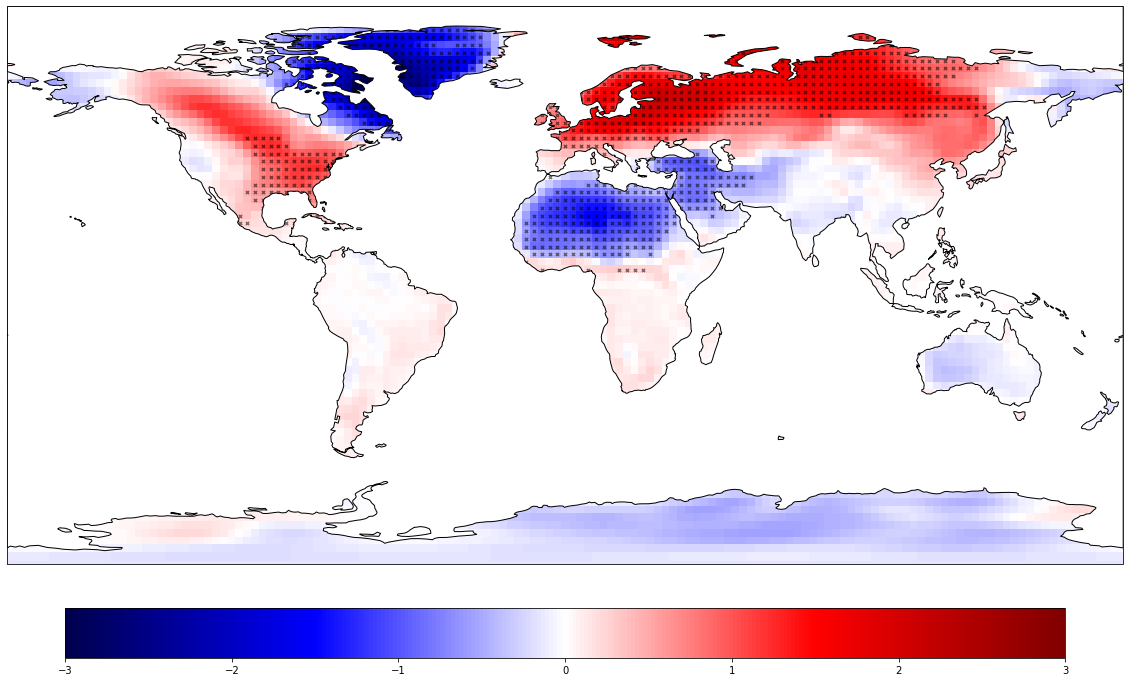

In [27]:
# Plotting the results
fig = plt.figure(figsize = (20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
cb = ax.pcolormesh(lon_cyc, slope_djf['lat'].values[:,0], slope_cyc, transform=ccrs.PlateCarree(), cmap='seismic', norm=colors.DivergingNorm(vcenter=0, vmin=-3, vmax=3))
ax.scatter(p_value_lon, p_value_lat, transform=ccrs.PlateCarree(), s=10, color='black', alpha=0.5, marker='x')
ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=1, edgecolor='k')
plt.colorbar(cb, orientation='horizontal', fraction=0.046, pad=0.04)